In [23]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.base import clone
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from itertools import combinations


# Function to compute permutation importance
def compute_permutation_importance(model, X_test, y_test, feature_names):
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    sorted_idx = result.importances_mean.argsort()
    plt.figure()
    plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(feature_names)[sorted_idx])
    plt.title("Permutation Importances (test set)")
    plt.tight_layout()
    plt.show()


# Function to plot learning curves
def plot_learning_curves(model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title("Learning curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()


# Data preprocessing function
def preprocess_titanic_data(data):
    data = data.drop('Cabin', axis=1)
    data['Age'] = data['Age'].fillna(data['Age'].median())
    data['Embarked'] = data['Embarked'].fillna(data['Embarked'].value_counts().index[0])

    LE = LabelEncoder()
    data['Sex'] = LE.fit_transform(data['Sex'])
    for v in ['C', 'S', 'Q']:
        data['Embarked_{}'.format(v)] = (data['Embarked'] == v).astype(int)
    features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_S', 'Embarked_Q']
    return data, features

# Function to split data into features and target
def split_data(data, features, target='Survived'):
    X = data[features]
    y = data[target]
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Function to train XGBoost model with default params
def train_xgboost(X_train, y_train, X_test, y_test, params = None ):
    if params == None:
        classifier = xgb.XGBClassifier(
            max_depth=12,
            subsample=0.33,
            objective='binary:logistic',
            n_estimators=100,
            learning_rate=0.01
        )
        eval_set = [(X_train, y_train), (X_test, y_test)]
        classifier.fit(
            X_train, y_train,
            early_stopping_rounds=12,
            eval_metric=["error", "logloss"],
            eval_set=eval_set,
            verbose=True
        )
    else:
        classifier = xgb.XGBClassifier(**params)
        eval_set = [(X_train, y_train), (X_test, y_test)]
        classifier.fit(
            X_train, y_train,
            early_stopping_rounds=12,
            eval_metric=["error", "logloss"],
            eval_set=eval_set,
            verbose=True
        )
    return classifier

# Function to tune hyperparameters using random search
def tune_hyperparameters(X_train, y_train, X_test, y_test):
    classifier = xgb.XGBClassifier(
        objective='binary:logistic'
    )
    param_grid = {
        'n_estimators': [100, 200, 300, 400],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [6, 8, 10, 12],
        'subsample': [0.33, 0.5, 0.66, 0.8],
        #'colsample_bytree': [0.33, 0.5, 0.66, 0.8],
        #'gamma': [0, 0.1, 0.2, 0.3],
        #'reg_alpha': [0, 0.1, 0.2, 0.3],
    }
    #random search
    random_search = RandomizedSearchCV(
        classifier, param_distributions=param_grid, n_iter=100,
        scoring='roc_auc', n_jobs=-1, cv=5, random_state=42, verbose=1
    )
    random_search.fit(X_train, y_train)

    return random_search, random_search.best_estimator_

# Function to display the results of RandomizedSearchCV
def display_search_results(search_results):
    means = search_results.cv_results_['mean_test_score']
    stds = search_results.cv_results_['std_test_score']
    params = search_results.cv_results_['params']
    
    # Calculate and print the information about the best parameters
    best_mean = search_results.best_score_
    average_mean = np.mean(means)
    print("Best parameters set found on development set:\n")
    print(search_results.best_params_)
    print(f"\nBest score: {best_mean:.3f}")
    print(f"Average score across all parameter combinations: {average_mean:.3f}")
    print(f"The best parameters are {((best_mean - average_mean) / average_mean) * 100:.2f}% better than the average.\n")
    
    print("Grid scores on development set:\n")
    for mean, std, params in sorted(zip(means, stds, params), key=lambda x: x[0], reverse=True):
        print(f"{mean:.3f} (+/-{std * 2:.3f}) for {params}")
    
    # Visualization of the distribution of scores
    plt.figure(figsize=(10, 6))
    sns.distplot(means, rug=True, hist=True)
    plt.axvline(x=best_mean, color='r', linestyle='--', label=f'Best score: {best_mean:.3f}')
    plt.axvline(x=average_mean, color='g', linestyle='-', label=f'Average score: {average_mean:.3f}')
    plt.title('Distribution of Scores for Parameter Combinations')
    plt.xlabel('Mean Test Score')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Function to evaluate model
def evaluate_model(model, X_test, y_test, feature_names):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"AUC: {roc_auc_score(y_test, y_prob):.2f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nFeature Importances:")
    sorted_idx = model.feature_importances_.argsort()
    sorted_feature_names = [feature_names[i] for i in sorted_idx]
    plt.barh(sorted_feature_names, model.feature_importances_[sorted_idx])
    plt.xlabel("Xgboost Feature Importance")
    plt.show()

    print("\nSHAP Summary Plot:")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar")

# Function to plot all PDPs
def plot_all_pdps(model, X, features):
    print("Plotting partial dependence plots...")
    for feature in features:
        fig, ax = plt.subplots(figsize=(8, 4))
        PartialDependenceDisplay.from_estimator(model, X, features=[feature], ax=ax)
    plt.show()

    print("Plotting two-way feature interaction partial dependence plots...")
    feature_pairs = combinations(features, 2)
    for pair in feature_pairs:
        fig, ax = plt.subplots(figsize=(8, 8))
        PartialDependenceDisplay.from_estimator(model, X, features=[pair], ax=ax)
    plt.show()


# Function to detect high leverage points in dataset
def detect_high_leverage_points(X):
    leverage_threshold = 2 * (X.shape[1] + 1) / X.shape[0]
    u, s, vh = np.linalg.svd(X, full_matrices=False)
    h_ii = np.sum(np.square(u), axis=1)  # Leverage scores
    high_leverage_points = np.where(h_ii > leverage_threshold)[0]
    return high_leverage_points

# Analyze model residuals for non-linearity checks
def analyze_model_residuals(model, X, y):
    y_pred = model.predict(X)
    residuals = y - y_pred
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    sns.distplot(residuals, bins=20, kde=True)
    plt.title('Residuals Distribution')
    plt.subplot(1, 2, 2)
    plt.scatter(y_pred, residuals)
    plt.title('Residuals vs Fitted')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()



In [30]:
# Main execution
titanic_data = pd.read_csv('titanic/train.csv')  # Modify with your path
titanic_data, features = preprocess_titanic_data(titanic_data)
X_train, X_test, y_train, y_test = split_data(titanic_data, features)

search, best_param = tune_hyperparameters(X_train, y_train, X_test, y_test)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


Best parameters set found on development set:

{'subsample': 0.33, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.05}

Best score: 0.864
Average score across all parameter combinations: 0.855
The best parameters are 1.06% better than the average.

Grid scores on development set:

0.864 (+/-0.020) for {'subsample': 0.33, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.05}
0.863 (+/-0.016) for {'subsample': 0.33, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05}
0.862 (+/-0.019) for {'subsample': 0.5, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05}
0.861 (+/-0.015) for {'subsample': 0.5, 'n_estimators': 200, 'max_depth': 12, 'learning_rate': 0.05}
0.861 (+/-0.029) for {'subsample': 0.33, 'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.1}
0.861 (+/-0.033) for {'subsample': 0.33, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.1}
0.861 (+/-0.018) for {'subsample': 0.5, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.05}
0.861 

C:\Users\nyihm\AppData\Local\Temp\ipykernel_126372\4082147880.py:144: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(means, rug=True, hist=True)


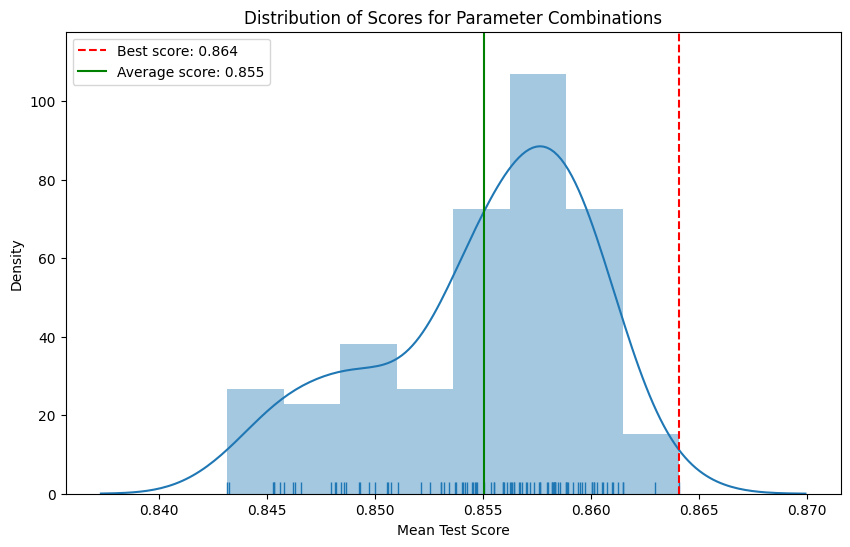

In [31]:
display_search_results(search)

[0]	validation_0-error:0.37640	validation_0-logloss:0.64226	validation_1-error:0.41341	validation_1-logloss:0.66103
[1]	validation_0-error:0.37640	validation_0-logloss:0.62512	validation_1-error:0.41341	validation_1-logloss:0.64416
[2]	validation_0-error:0.37640	validation_0-logloss:0.60856	validation_1-error:0.41341	validation_1-logloss:0.62797
[3]	validation_0-error:0.37640	validation_0-logloss:0.59197	validation_1-error:0.41341	validation_1-logloss:0.61183
[4]	validation_0-error:0.23315	validation_0-logloss:0.57805	validation_1-error:0.26257	validation_1-logloss:0.59869
[5]	validation_0-error:0.22472	validation_0-logloss:0.56486	validation_1-error:0.24022	validation_1-logloss:0.58741
[6]	validation_0-error:0.20787	validation_0-logloss:0.55276	validation_1-error:0.23464	validation_1-logloss:0.57495
[7]	validation_0-error:0.20787	validation_0-logloss:0.54069	validation_1-error:0.23464	validation_1-logloss:0.56446
[8]	validation_0-error:0.20787	validation_0-logloss:0.53004	validation_1

c:\Users\nyihm\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\nyihm\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


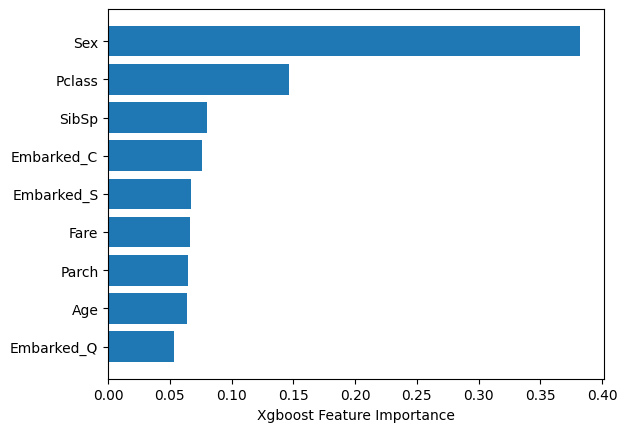


SHAP Summary Plot:


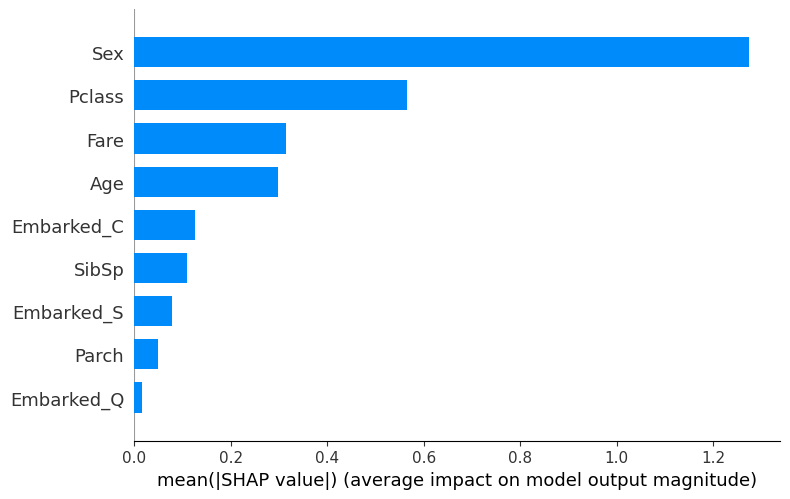

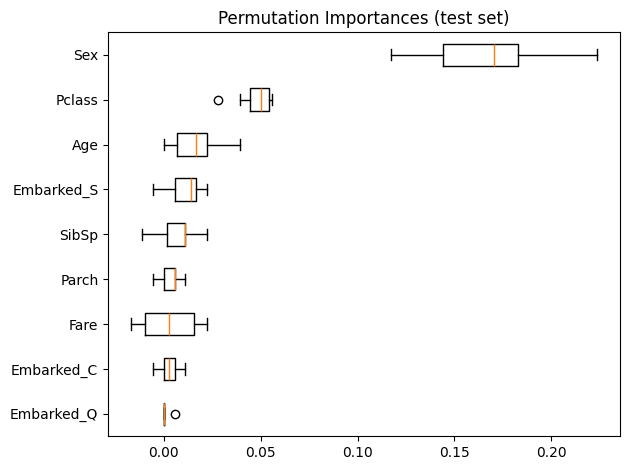

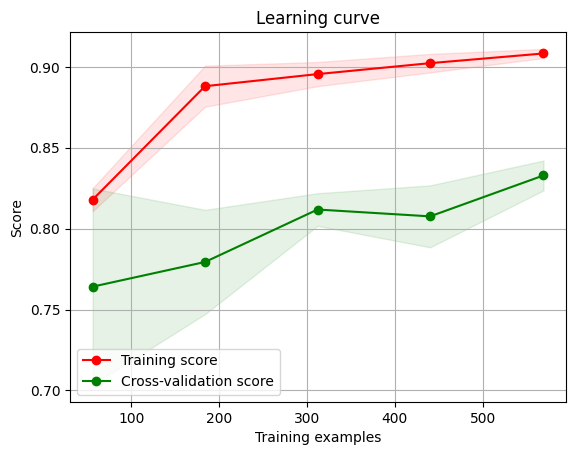

High leverage points (indices): [  5  17  31  48  52  59  89 175 179 202 210 230 232 268 278 282 284 329
 331 344 348 351 367 368 370 371 381 382 446 476 484 495 503 517 524 543
 582 622 650 705]


C:\Users\nyihm\AppData\Local\Temp\ipykernel_126372\4082147880.py:206: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals, bins=20, kde=True)


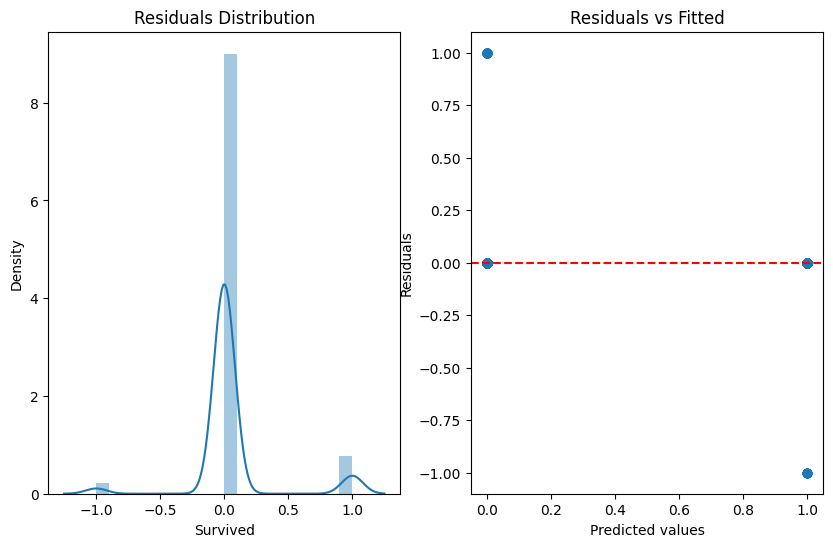

Plotting partial dependence plots...


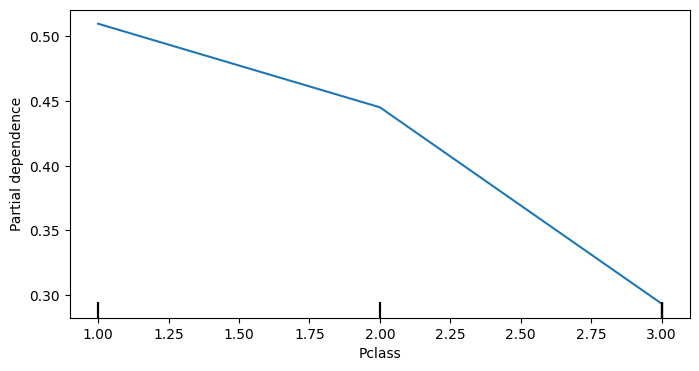

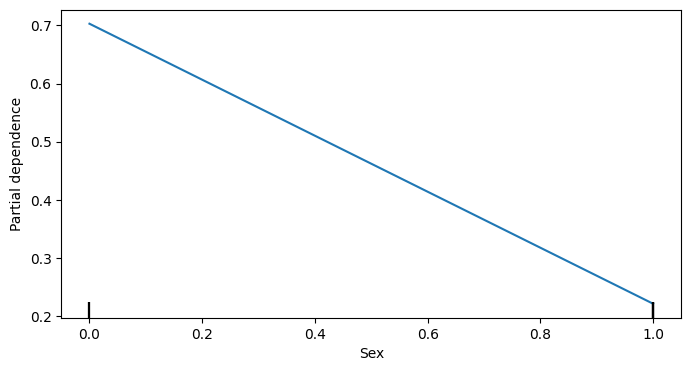

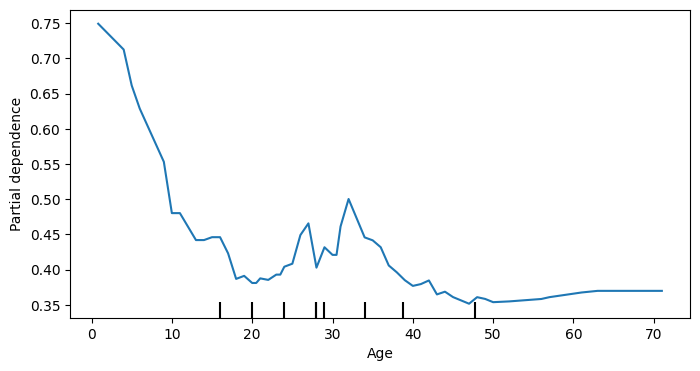

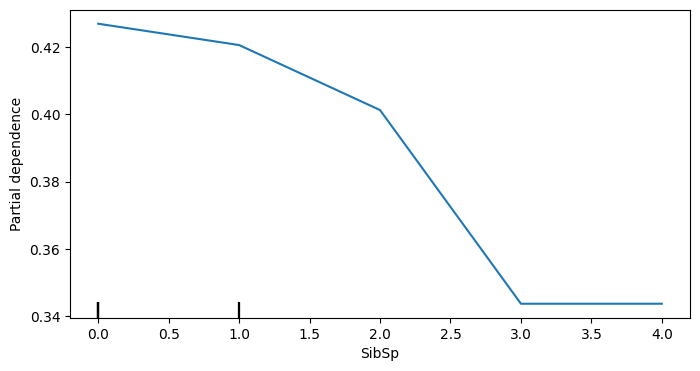

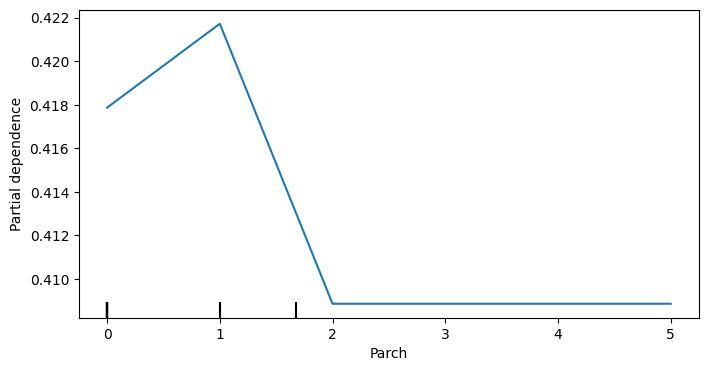

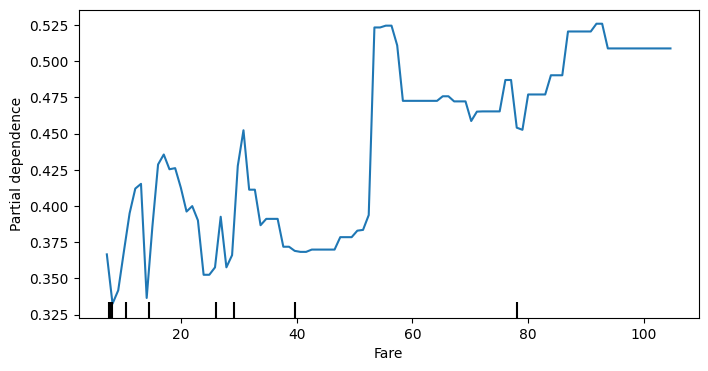

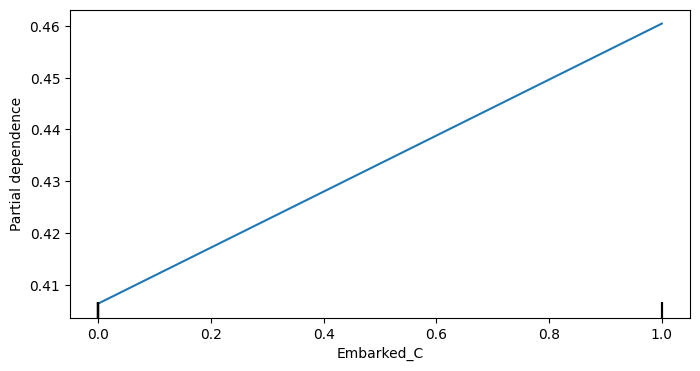

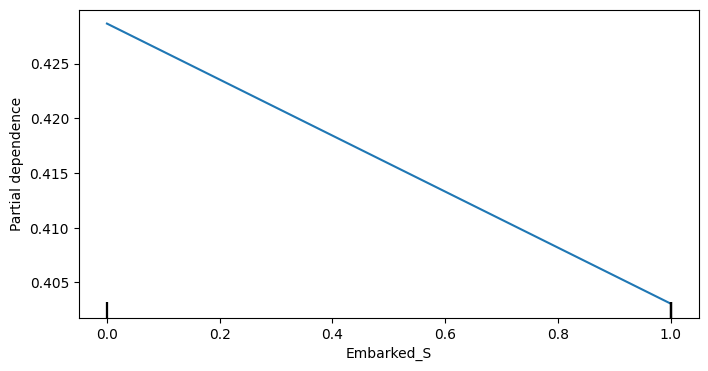

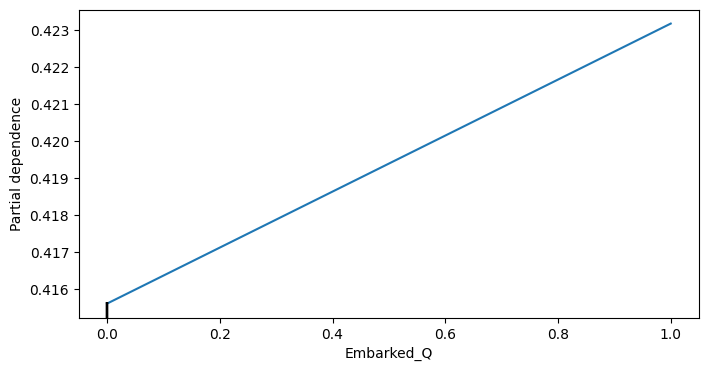

Plotting two-way feature interaction partial dependence plots...


C:\Users\nyihm\AppData\Local\Temp\ipykernel_126372\4082147880.py:187: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8, 8))


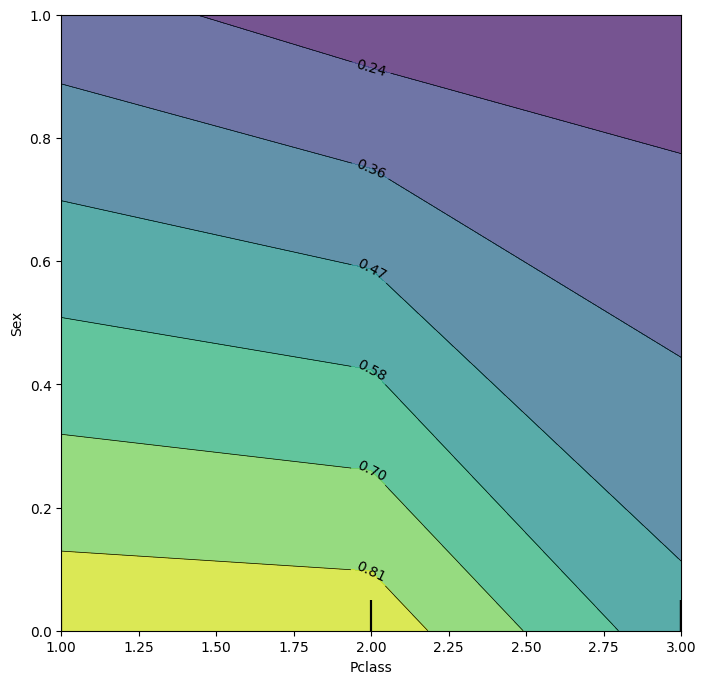

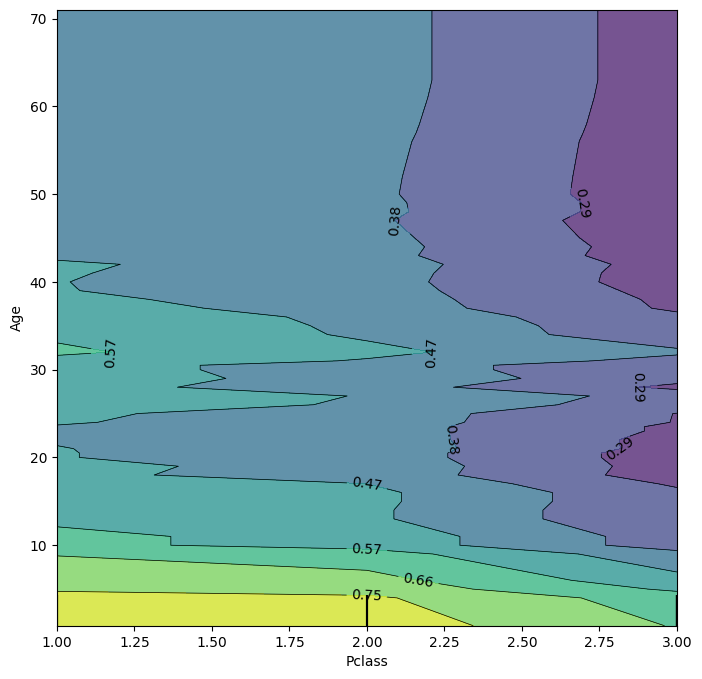

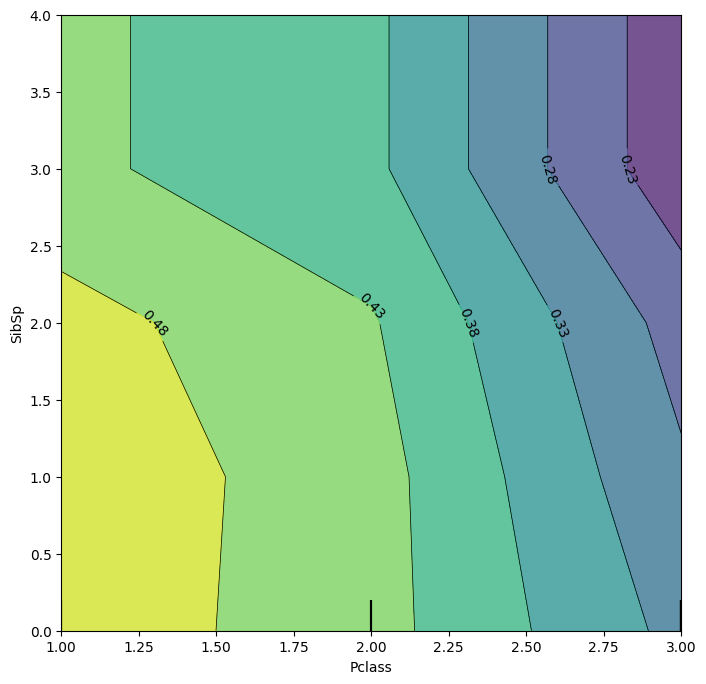

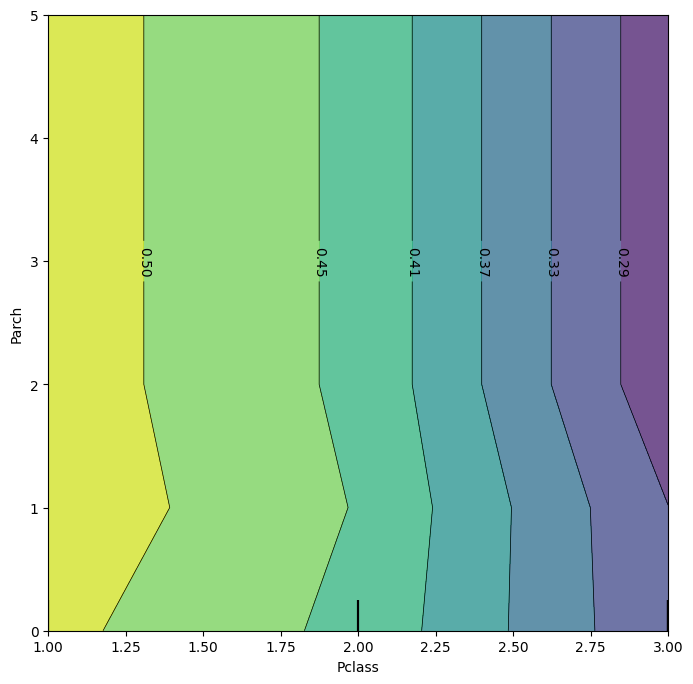

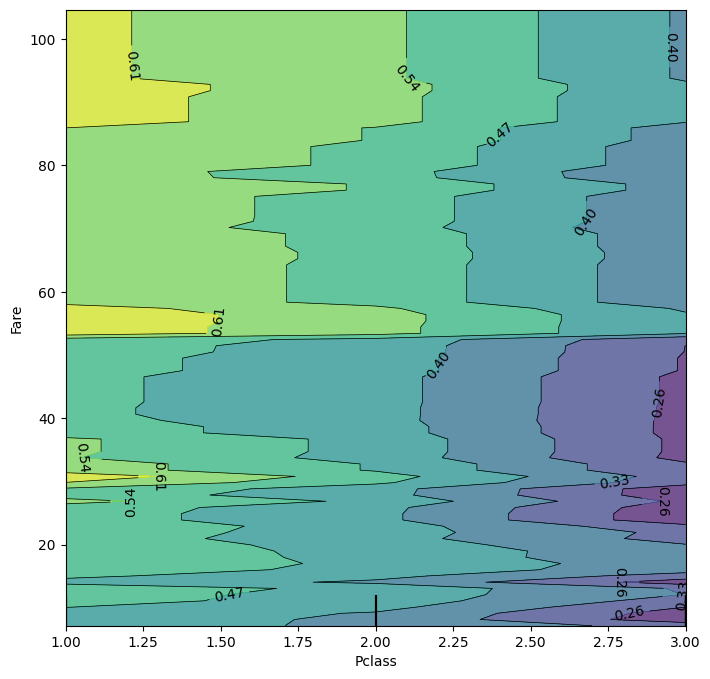

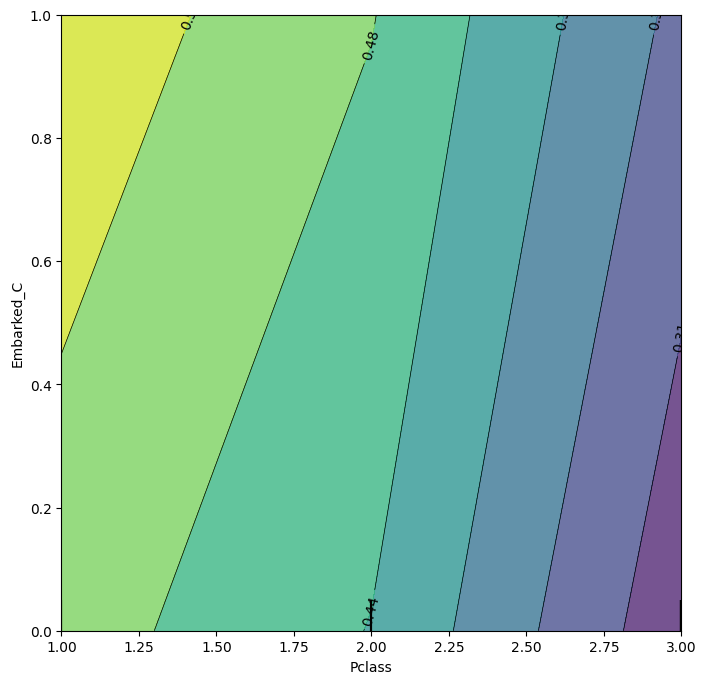

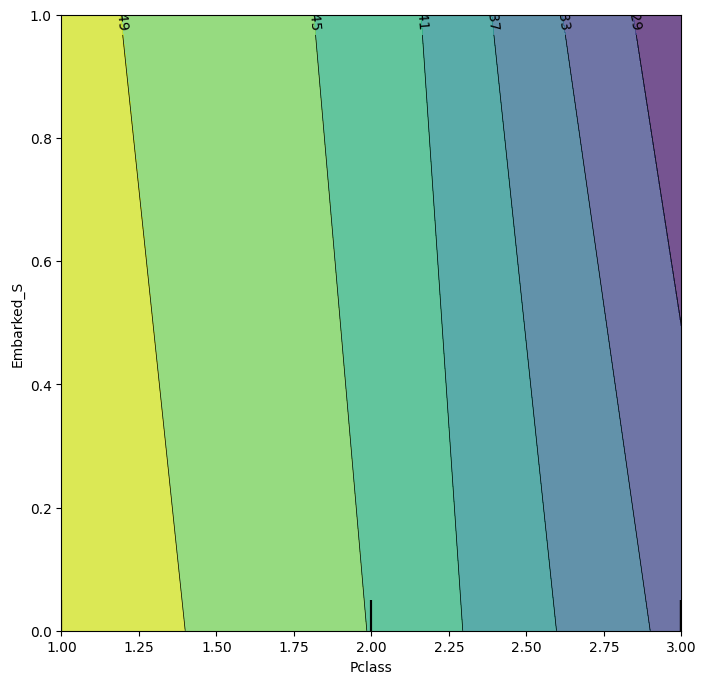

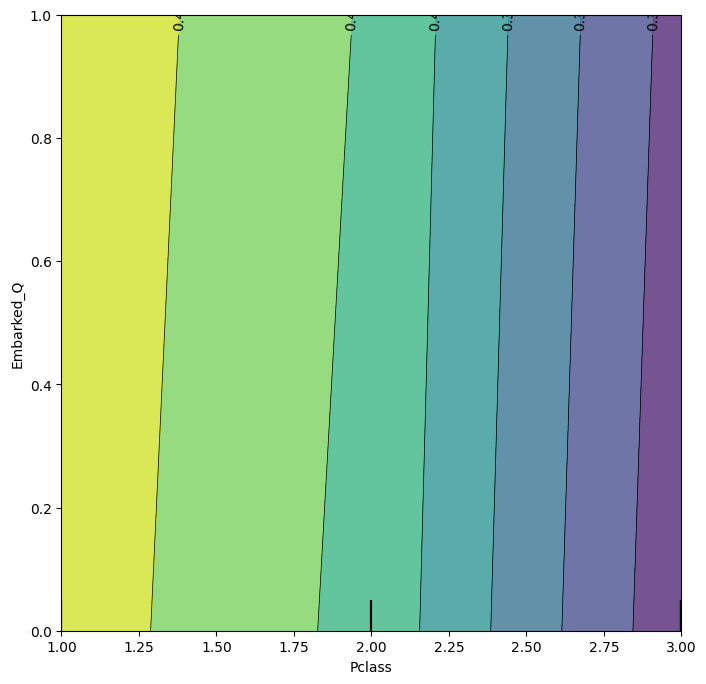

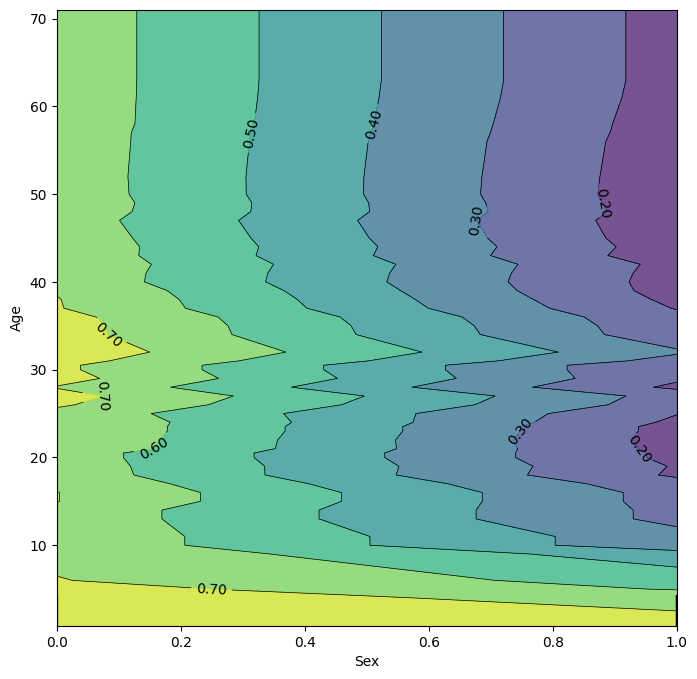

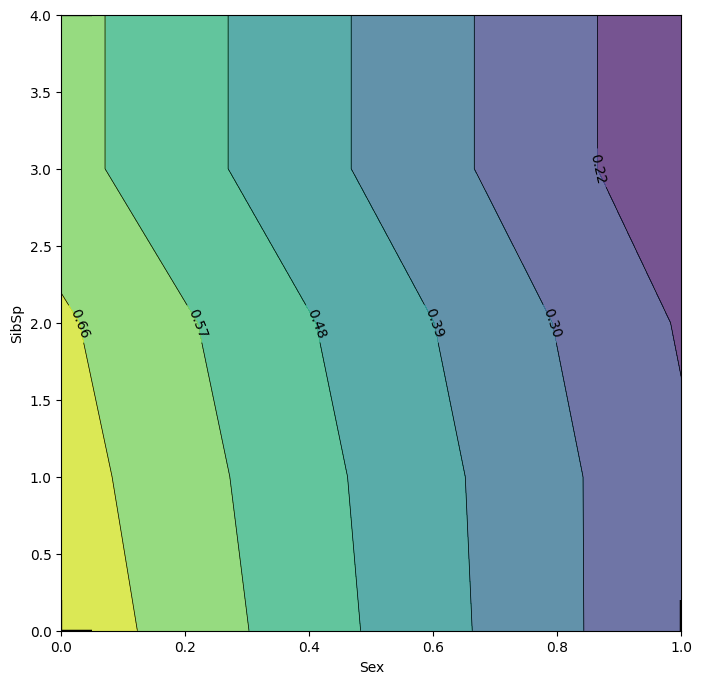

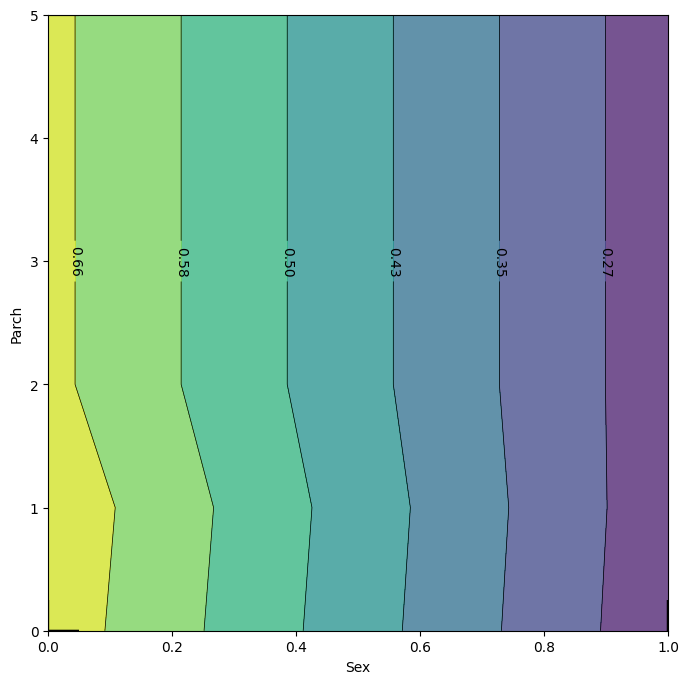

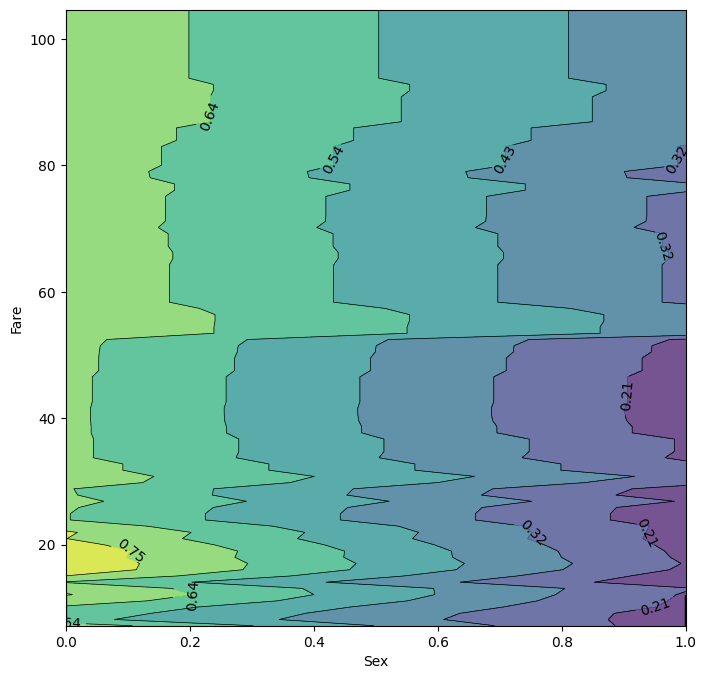

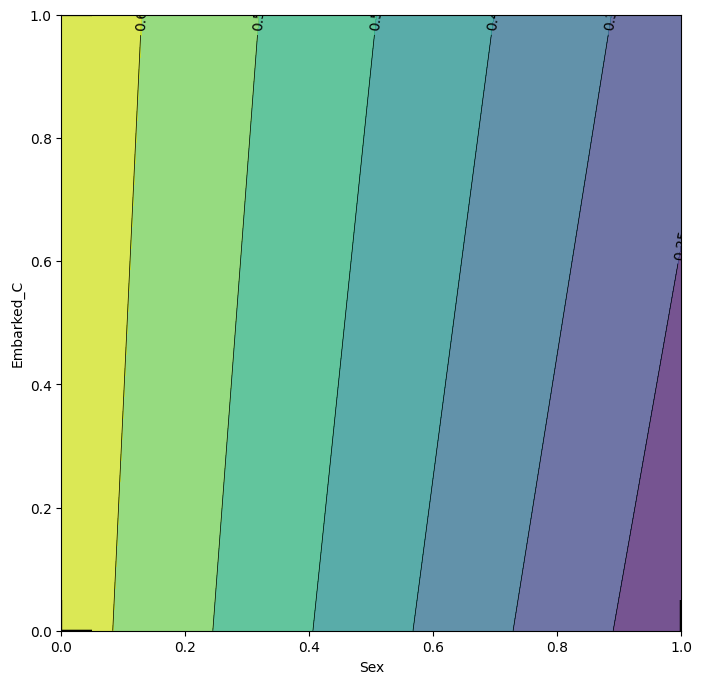

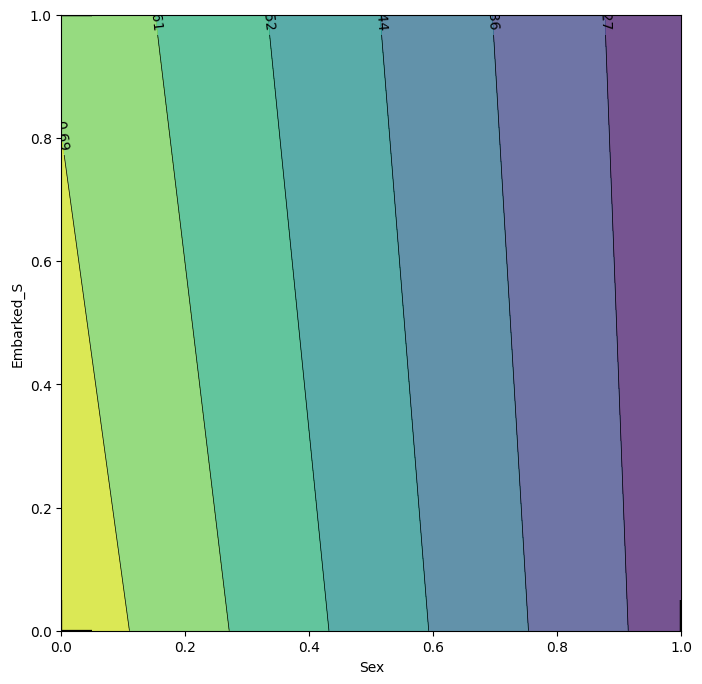

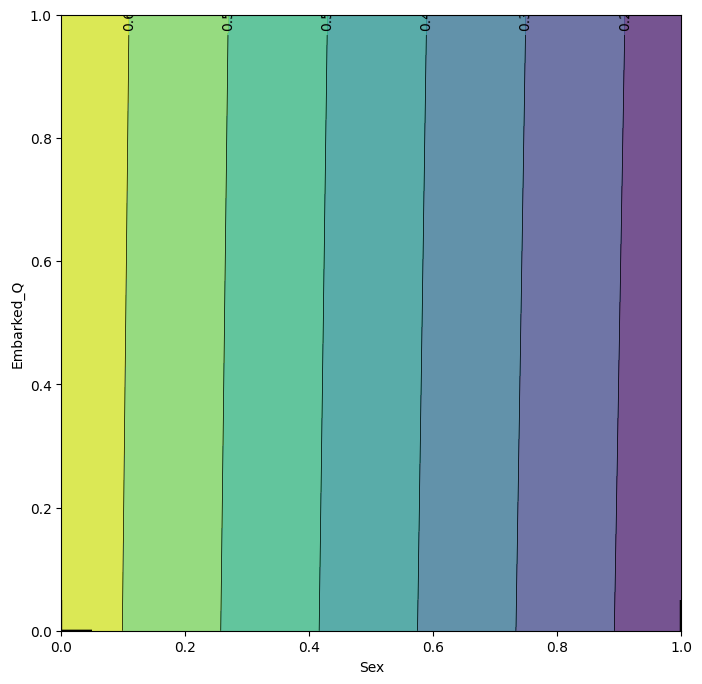

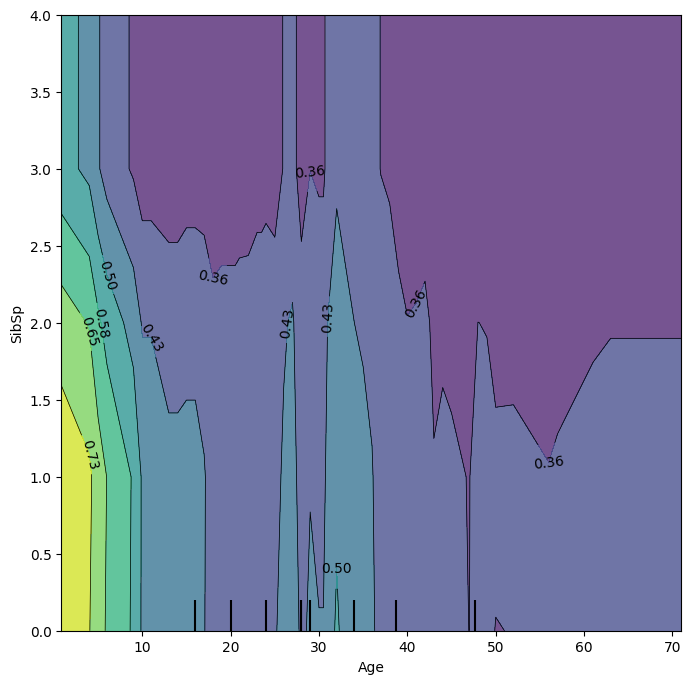

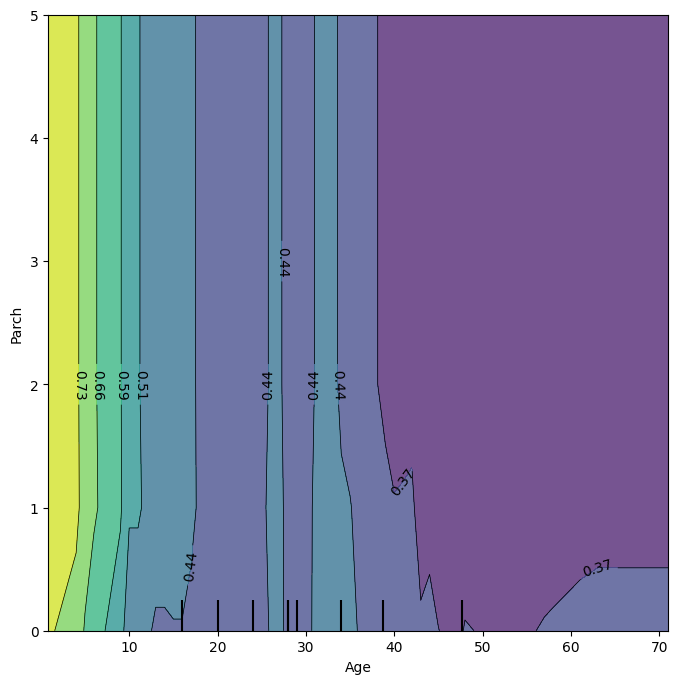

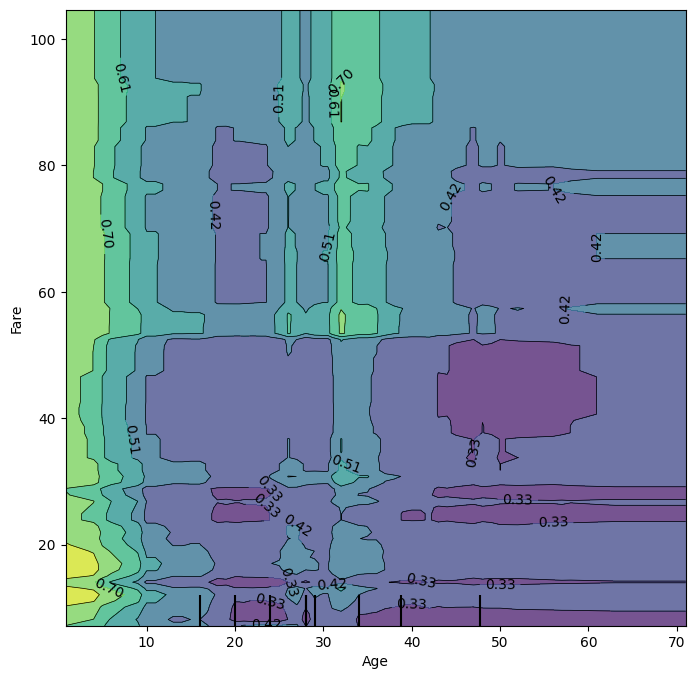

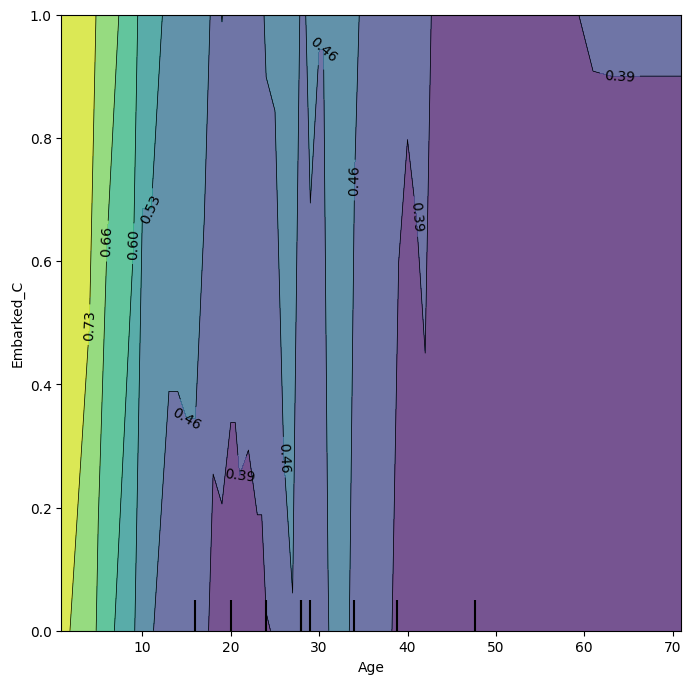

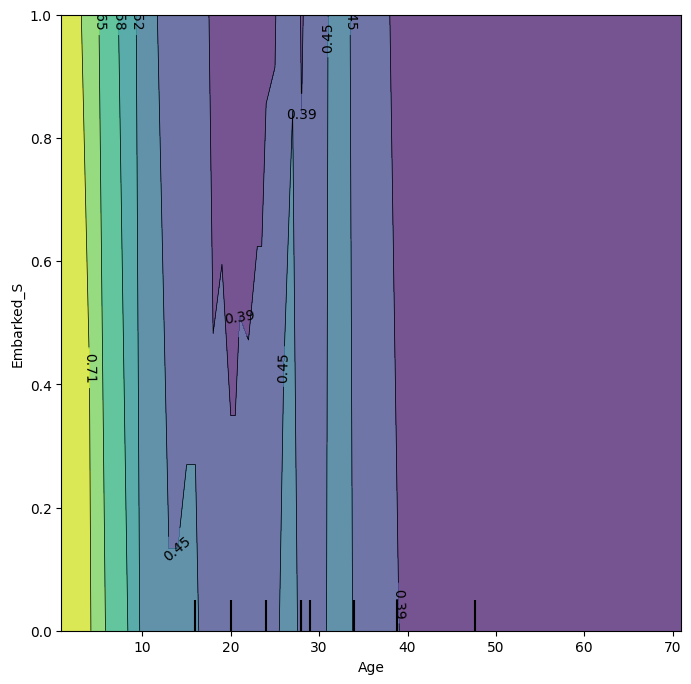

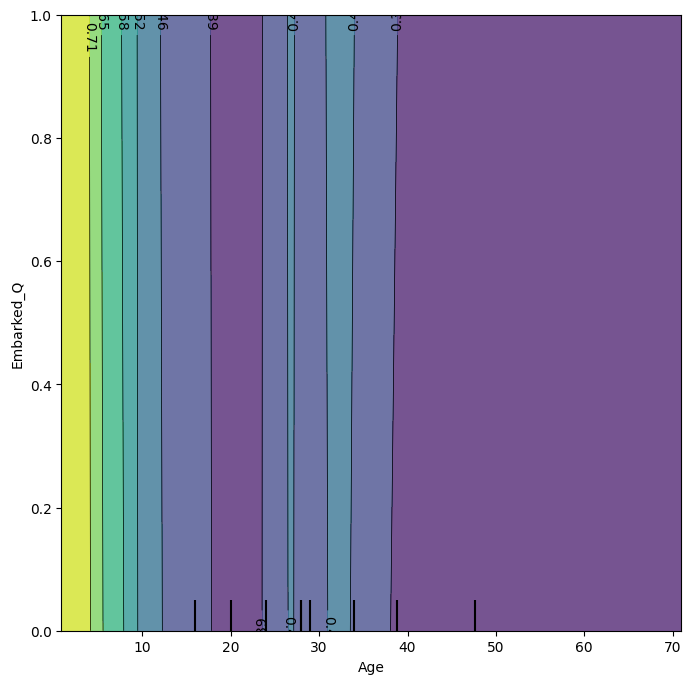

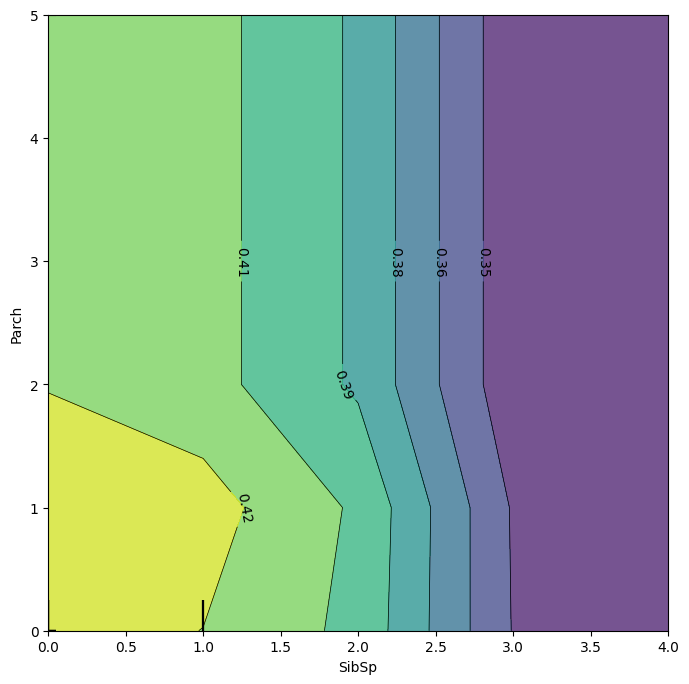

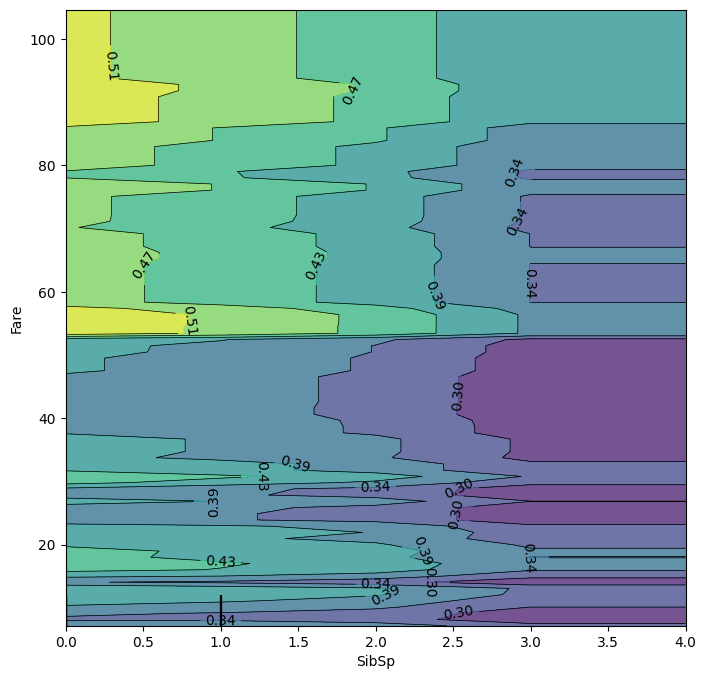

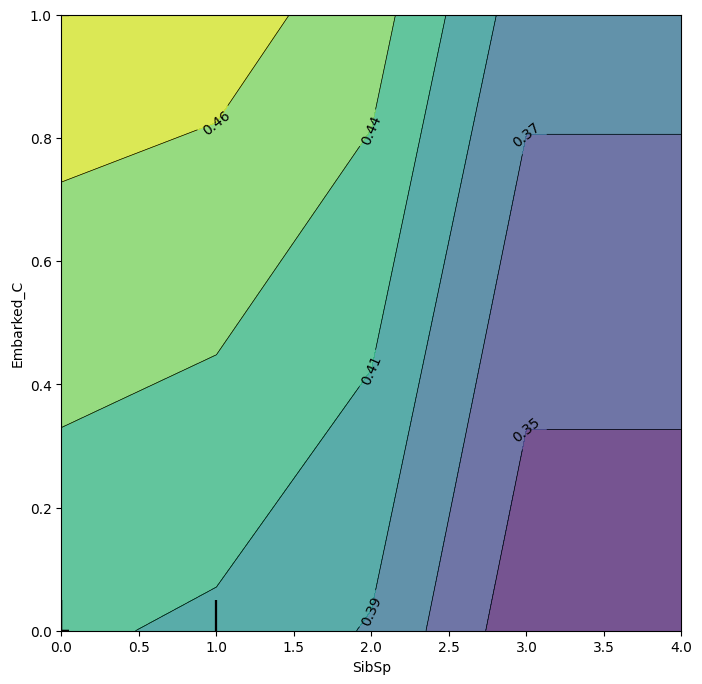

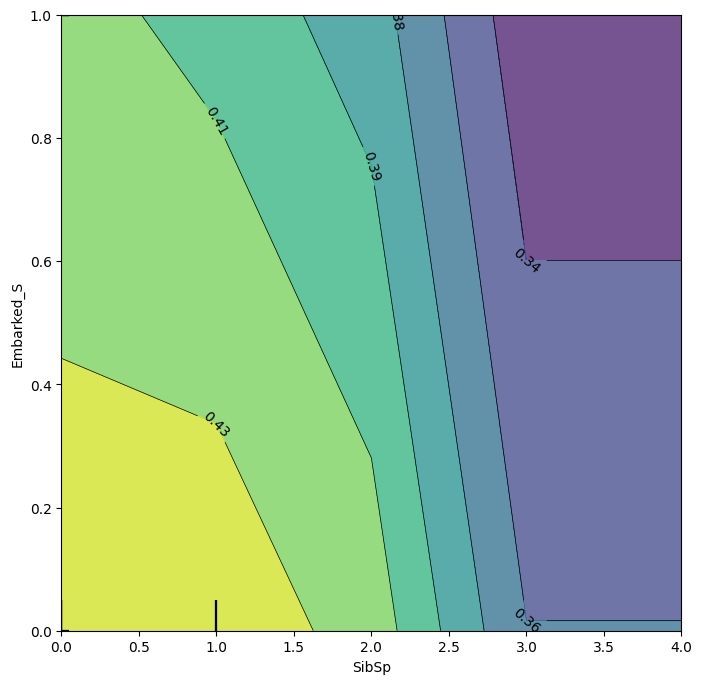

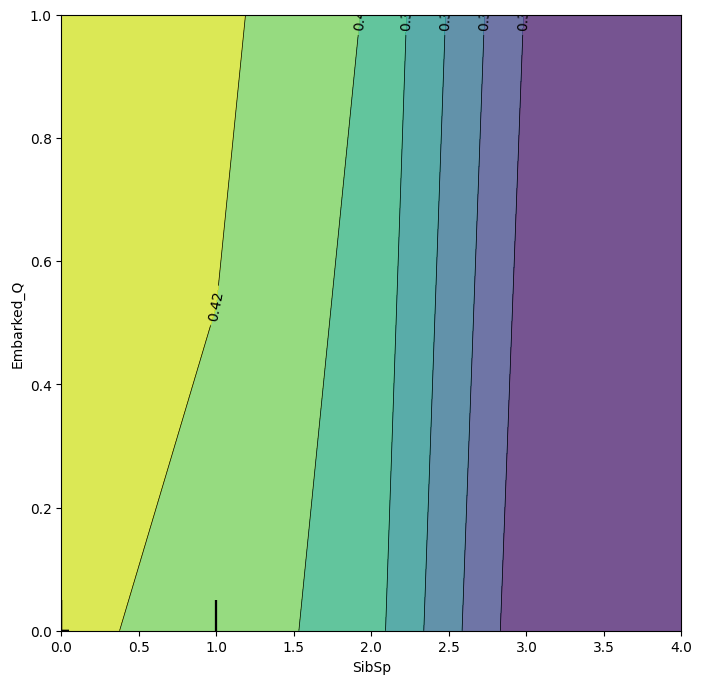

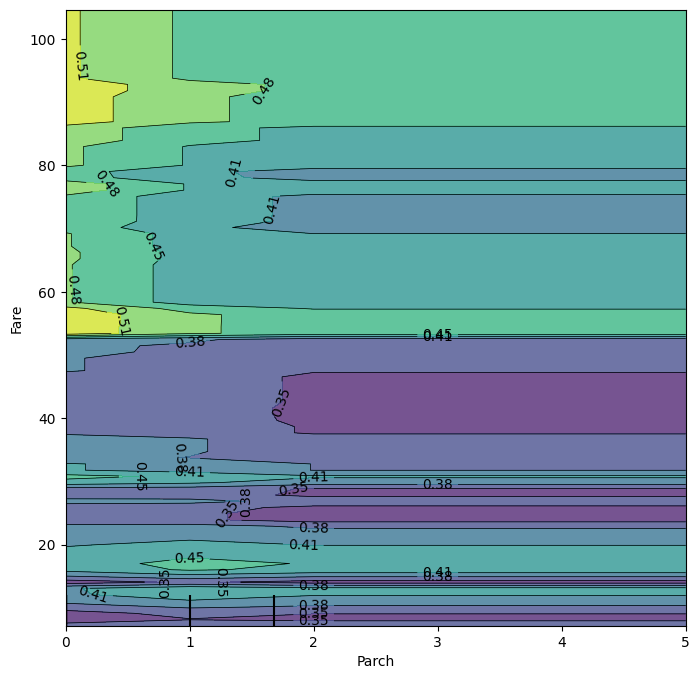

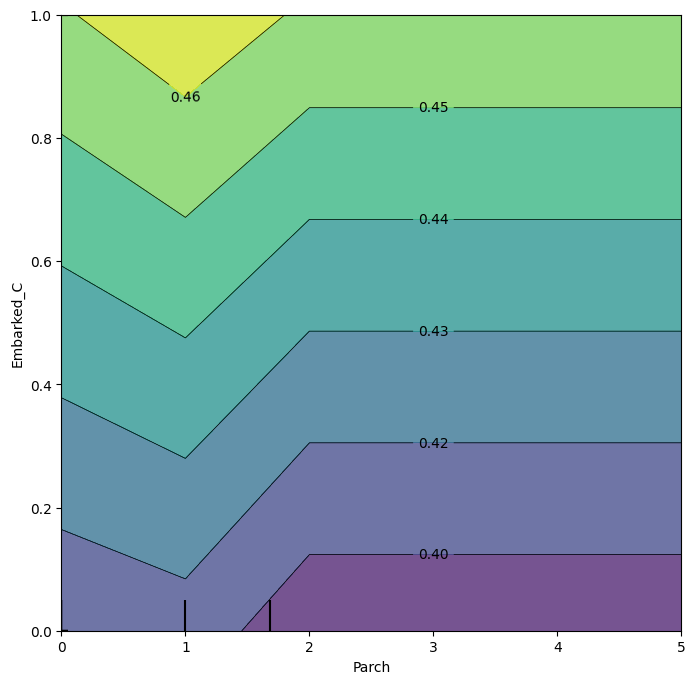

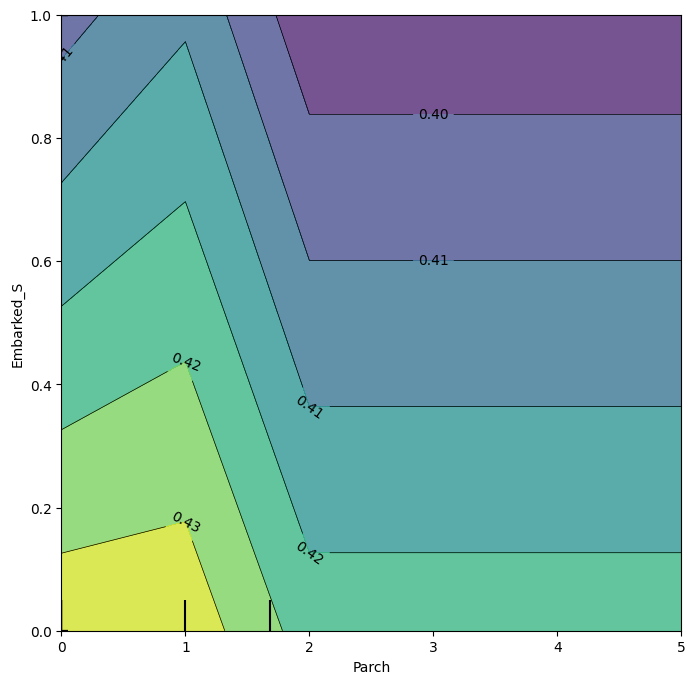

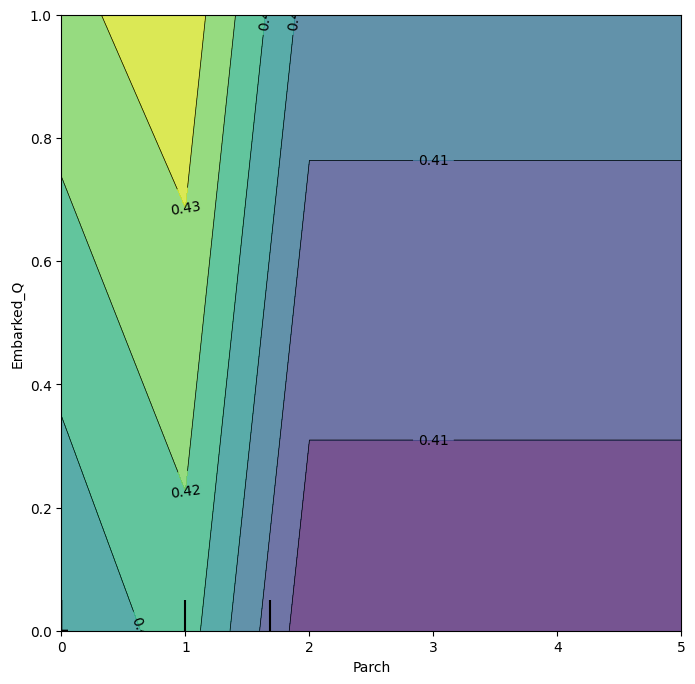

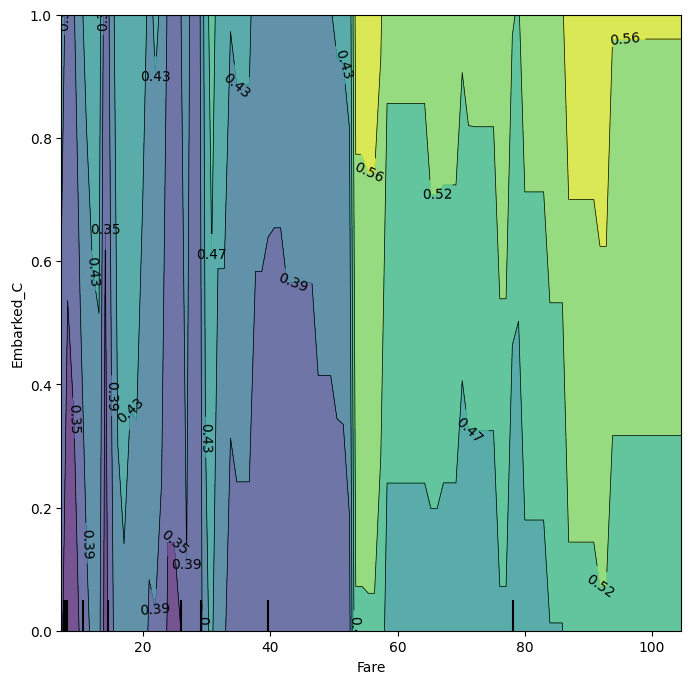

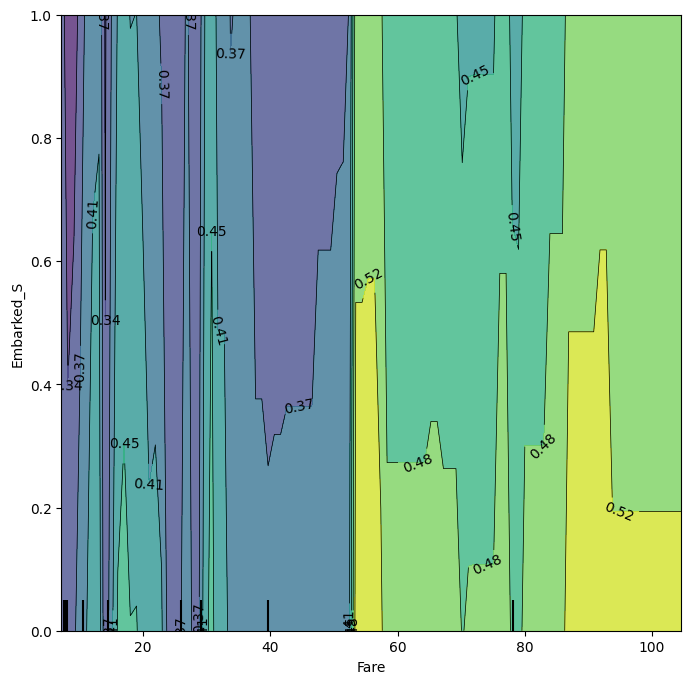

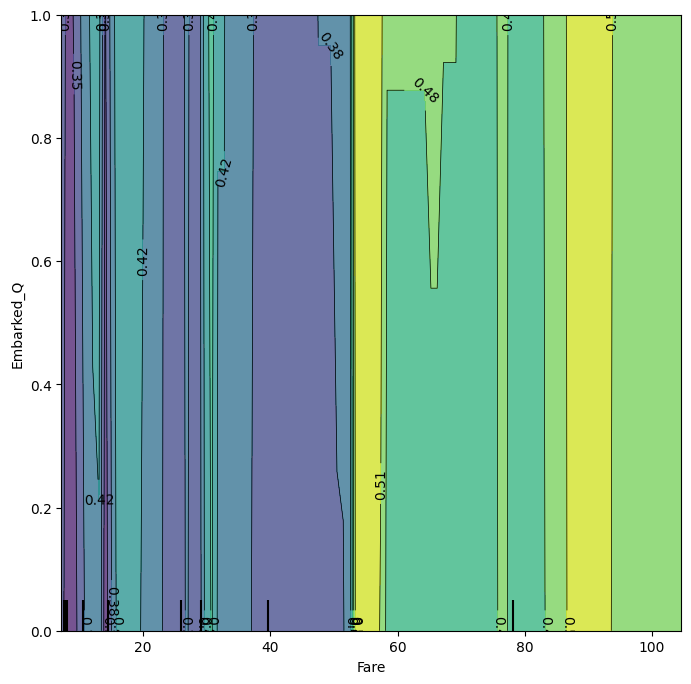

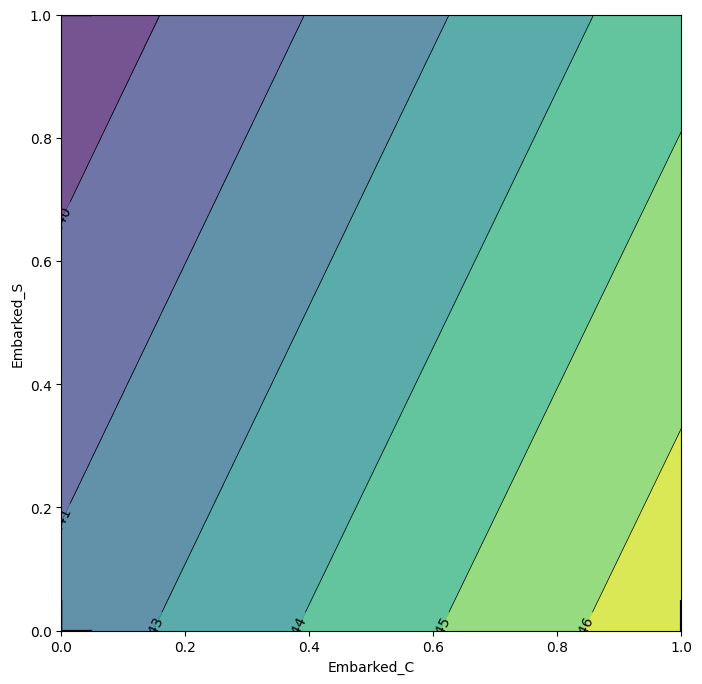

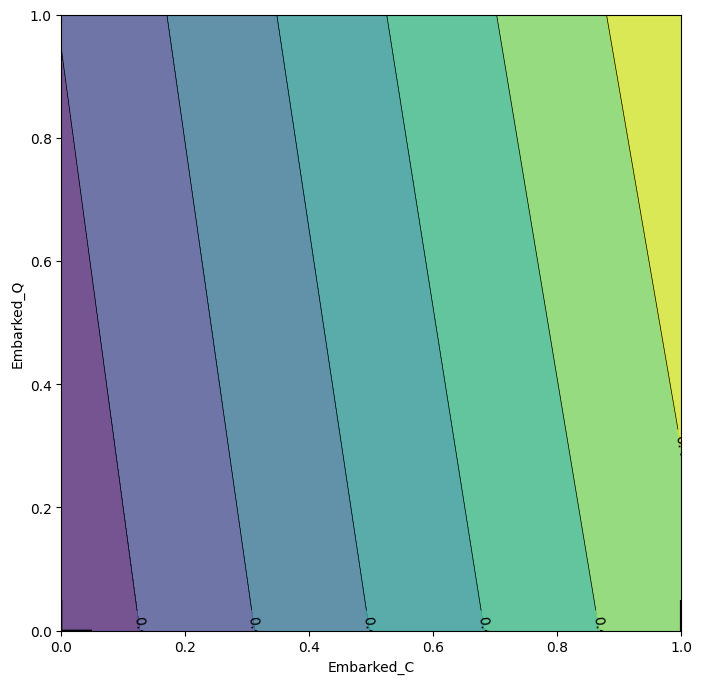

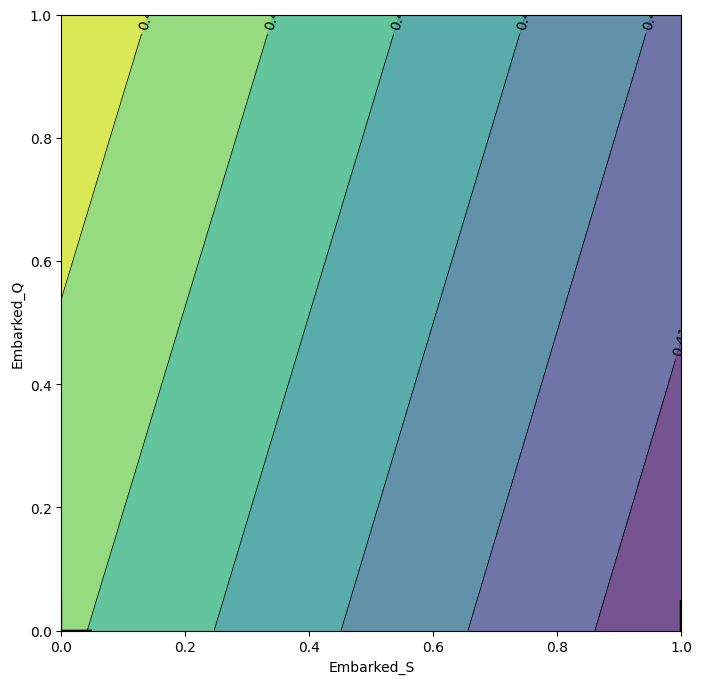

In [32]:
titanic_model = train_xgboost(X_train, y_train, X_test, y_test, best_param.get_params())
evaluate_model(titanic_model, X_test, y_test, features)
# Sample usage with Titanic data (assuming 'titanic_model', 'X_train', 'X_test', 'y_train', 'y_test', and 'features' are already defined)
compute_permutation_importance(titanic_model, X_test, y_test, features)
plot_learning_curves(titanic_model, X_train, y_train, cv=5)

high_leverage_points = detect_high_leverage_points(X_train.values)
print("High leverage points (indices):", high_leverage_points)

# Analyze model residuals
analyze_model_residuals(titanic_model, X_train, y_train)

plot_all_pdps(titanic_model, X_test, features)